In [1]:
import numpy as np
import pandas as pd

import torch

In [2]:
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

In [3]:
matplotlib.rc('font', size=22)

In [4]:
import sys

In [5]:
from copy import deepcopy

In [6]:
sys.path.append('../')
sys.path.append('../../')

In [7]:
!ls -l ../data/*.csv

-rw-r--r-- 1 nikita nikita      11031 июн 11 13:19 ../data/sample_submission.csv
-rw-r--r-- 1 nikita nikita     408868 июн 11 13:19 ../data/specs.csv
-rw-r--r-- 1 nikita nikita  398327801 июн 11 13:19 ../data/test.csv
-rw-r--r-- 1 nikita nikita      30664 июн 11 13:19 ../data/test_ids.csv
-rw-r--r-- 1 nikita nikita 3878373423 июн 11 13:23 ../data/train.csv
-rw-r--r-- 1 nikita nikita    1124229 июн 11 13:23 ../data/train_labels.csv


In [8]:
train_target = pd.read_csv('../data/train_labels.csv')

In [9]:
train_target.head(5)

,game_session,installation_id,title,num_correct,num_incorrect,accuracy,accuracy_group
0,6bdf9623adc94d89,0006a69f,Mushroom Sorter (Assessment),1,0,1.0,3
1,77b8ee947eb84b4e,0006a69f,Bird Measurer (Assessment),0,11,0.0,0
2,901acc108f55a5a1,0006a69f,Mushroom Sorter (Assessment),1,0,1.0,3
3,9501794defd84e4d,0006a69f,Mushroom Sorter (Assessment),1,1,0.5,2
4,a9ef3ecb3d1acc6a,0006a69f,Bird Measurer (Assessment),1,0,1.0,3


In [10]:
df_vectors = pd.read_pickle('../data/mles_embeddings.pickle').set_index('game_session')
embedding_columns = df_vectors.columns.tolist()
df_vectors = pd.merge(df_vectors, train_target.set_index('game_session'), left_index=True, right_index=True)
df_vectors.head()

,v000,v001,v002,v003,v004,v005,v006,v007,v008,v009,...,v096,v097,v098,v099,installation_id,title,num_correct,num_incorrect,accuracy,accuracy_group
game_session,,,,,,,,,,,,,,,,,,,,,
6bdf9623adc94d89,0.095138,0.141952,0.027416,0.139011,-0.053046,-0.058230,0.146721,-0.090885,-0.088227,-0.145392,...,-0.065254,0.125020,-0.137997,0.019650,0006a69f,Mushroom Sorter (Assessment),1,0,1.0,3
77b8ee947eb84b4e,0.095068,0.143024,0.027802,0.150359,-0.037869,-0.060580,0.153769,-0.104053,-0.090728,-0.143113,...,-0.067230,0.148582,-0.128838,0.017864,0006a69f,Bird Measurer (Assessment),0,11,0.0,0
901acc108f55a5a1,0.094407,0.147073,0.055425,0.121252,-0.056256,-0.051248,0.149238,-0.116133,-0.091959,-0.148355,...,-0.046085,0.135020,-0.141256,0.033604,0006a69f,Mushroom Sorter (Assessment),1,0,1.0,3
9501794defd84e4d,0.130049,0.143942,0.026767,0.138959,-0.052457,-0.073947,0.152875,-0.091709,-0.107313,-0.140731,...,-0.064106,0.125177,-0.102989,-0.031263,0006a69f,Mushroom Sorter (Assessment),1,1,0.5,2
a9ef3ecb3d1acc6a,0.126146,0.123507,0.022491,0.145197,-0.019378,-0.072870,0.150522,-0.102511,-0.104288,-0.128316,...,-0.063566,0.140776,-0.129886,-0.019137,0006a69f,Bird Measurer (Assessment),1,0,1.0,3


In [11]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [12]:
df_pca = df_vectors.copy()

In [13]:
pca = PCA(n_components=2)
pca.fit(df_pca[embedding_columns].values)
np.sum(pca.explained_variance_ratio_)

0.6113363

In [14]:
pca_results = pca.transform(df_pca[embedding_columns].values)
df_pca['_pca_x'] = pca_results[:, 0]
df_pca['_pca_y'] = pca_results[:, 1]

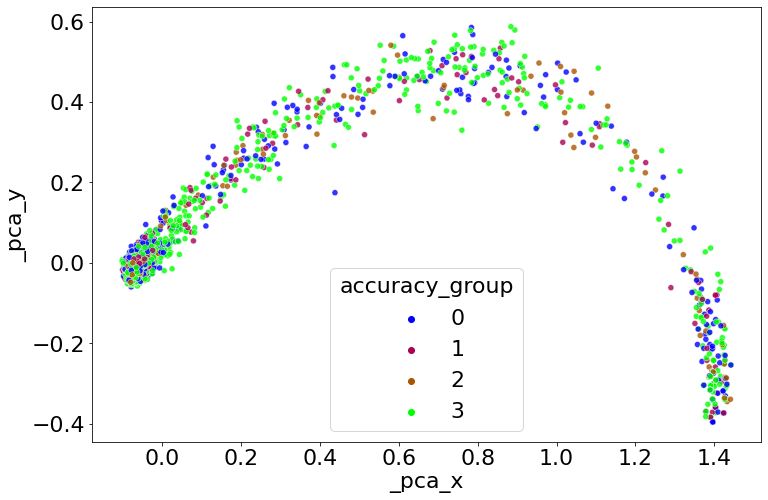

In [15]:
col_target = 'accuracy_group'
_, axs = plt.subplots(1, 1, figsize=(12, 8))
sns.scatterplot(
    x='_pca_x', y='_pca_y',
    hue=col_target,
    # style='bins',
    data=df_pca.sample(n=10000),
    palette='brg',
    alpha=0.8,
    ax=axs,
    markers=['o', 'd', '*' , '.']
)
plt.show()

In [16]:
if len(df_pca) > 40000:
    df_tsne = df_pca.sample(n=40000).copy()
else:
    df_tsne = df_pca.copy()

In [17]:
tsne = TSNE(n_components=2, verbose=1, n_iter=300, metric='cosine')
tsne_results = tsne.fit_transform(df_tsne[embedding_columns].values)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 17690 samples in 0.002s...
[t-SNE] Computed neighbors for 17690 samples in 4.095s...
[t-SNE] Computed conditional probabilities for sample 1000 / 17690
[t-SNE] Computed conditional probabilities for sample 2000 / 17690
[t-SNE] Computed conditional probabilities for sample 3000 / 17690
[t-SNE] Computed conditional probabilities for sample 4000 / 17690
[t-SNE] Computed conditional probabilities for sample 5000 / 17690
[t-SNE] Computed conditional probabilities for sample 6000 / 17690
[t-SNE] Computed conditional probabilities for sample 7000 / 17690
[t-SNE] Computed conditional probabilities for sample 8000 / 17690
[t-SNE] Computed conditional probabilities for sample 9000 / 17690
[t-SNE] Computed conditional probabilities for sample 10000 / 17690
[t-SNE] Computed conditional probabilities for sample 11000 / 17690
[t-SNE] Computed conditional probabilities for sample 12000 / 17690
[t-SNE] Computed conditional probabilities for sam

In [18]:
df_tsne['tSNE[0]'] = tsne_results[:, 0]
df_tsne['tSNE[1]'] = tsne_results[:, 1]

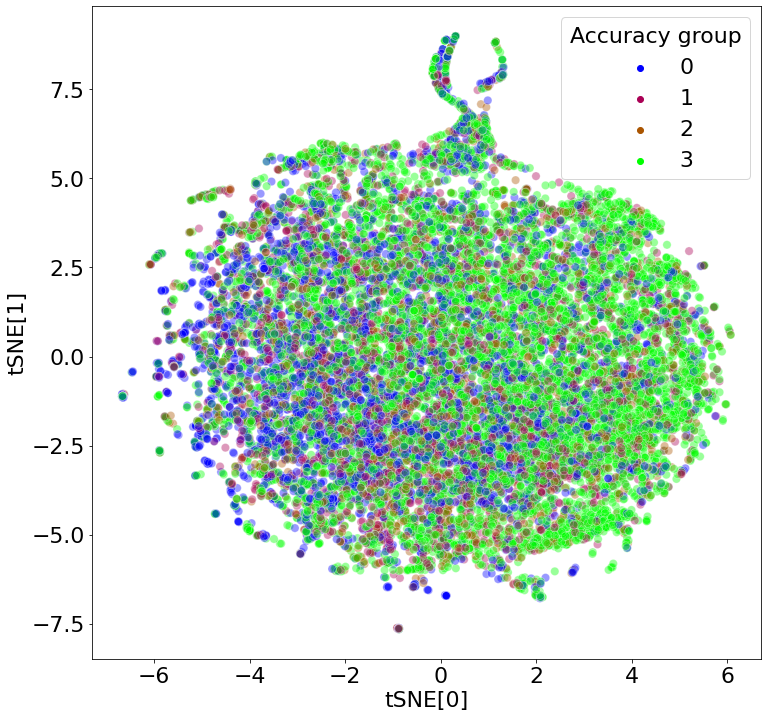

In [19]:
for col_target, col_name, palette in zip(
    ['accuracy_group'],
    ['Accuracy group'],
    ['brg'] #, 'brg', 'hsv']  #'gnuplot2'
):
    _, axs = plt.subplots(1, 1, figsize=(12, 12))
    sns.scatterplot(
        x='tSNE[0]', y='tSNE[1]',
        hue=col_name,
        data=df_tsne[lambda x: ~x[col_target].isna()].rename(columns={col_target: col_name}),
        palette=palette,
        alpha=0.4, s=70,
        ax=axs,
    )
    # plt.show()

    plt.savefig(f'bowl-tsne-{col_target}.pdf')

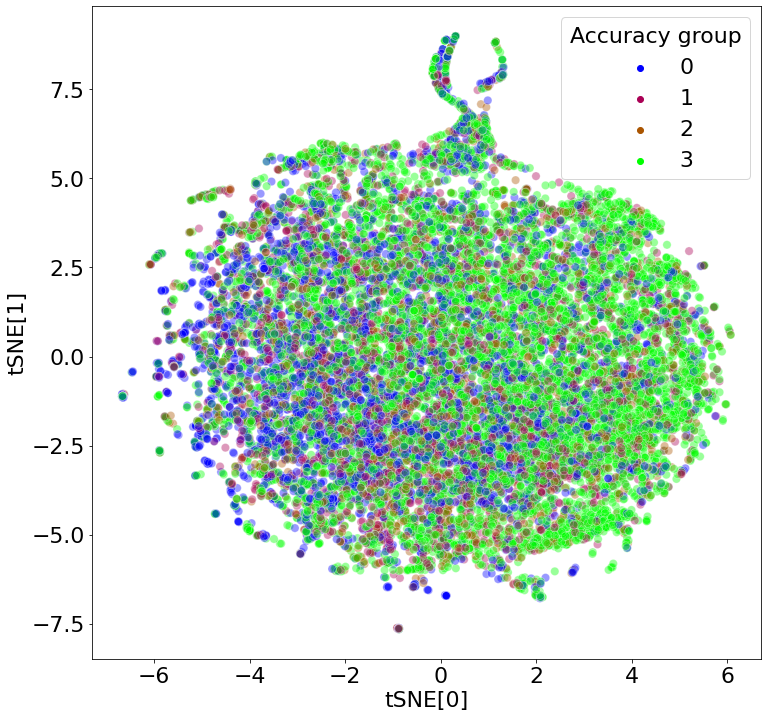

In [21]:
for col_target, col_name, palette in zip(
    ['accuracy_group'],
    ['Accuracy group'],
    ['brg'] #, 'brg', 'hsv']  #'gnuplot2'
):
    _, axs = plt.subplots(1, 1, figsize=(12, 12))
    sns.scatterplot(
        x='tSNE[0]', y='tSNE[1]',
        hue=col_name,
        data=df_tsne[lambda x: ~x[col_target].isna()].rename(columns={col_target: col_name}),
        palette=palette,
        alpha=0.4, s=70,
        ax=axs,
    )
    # plt.show()

    plt.savefig(f'iclr-bowl-tsne-{col_target}.pdf')